<a href="https://colab.research.google.com/github/stumac2606/Shot_classification/blob/main/TensorFlow_Tennis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mediapipe opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 27.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [ ]:
import cv2
import mediapipe as mp
import os
import json
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=1)

mp_drawing = mp.solutions.drawing_utils


In [ ]:
# Directories for forehand and backhand images
forehand_dir = "/content/Tennis/Forehand/"
backhand_dir = "/content/Tennis/Backhand/"

In [ ]:
output_directory = "/content/Tennis/"
output_file = "pose_data_with_labels.json"

In [ ]:
# Function to extract pose keypoints from images
def process_images(image_directory, label):
    pose_data = []

    for filename in os.listdir(image_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_directory, filename)

            # Read image with OpenCV
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # MediaPipe expects RGB images

            # Perform pose detection
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                # Extract keypoints
                keypoints = []
                for landmark in results.pose_landmarks.landmark:
                    keypoints.append([landmark.x, landmark.y, landmark.z])  # Normalize coordinates to [0, 1]

                # Add keypoints and label to the dataset
                pose_data.append({
                    "keypoints": keypoints,
                    "label": label
                })

    return pose_data

In [ ]:
# Process both forehand and backhand images
forehand_pose_data = process_images(forehand_dir, "forehand")
backhand_pose_data = process_images(backhand_dir, "backhand")


In [ ]:
# Combine data
all_pose_data = forehand_pose_data + backhand_pose_data

In [ ]:
# Check if the directory exists, if not, create it
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the data with labels to a JSON file
with open(output_file, "w") as f:
    json.dump(all_pose_data, f)

print(f"Pose data with labels saved to {output_file}")

Pose data with labels saved to pose_data_with_labels.json


# **Training the model **

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# Load and process the data as before
X = []  # Feature data (pose keypoints)
y = []  # Labels (forehand or backhand)

with open("/content/Tennis/pose_data_with_labels.json", "r") as f:
    data = json.load(f)

for entry in data:
    keypoints = [coord for kp in entry["keypoints"] for coord in kp]  # Flatten keypoints to a 1D list
    X.append(keypoints)
    y.append(1 if entry["label"] == "forehand" else 0)  # Convert labels to numeric

X = np.array(X)
y = np.array(y)


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer based on the number of features
    tf.keras.layers.Dense(128, activation='relu'),     # Hidden layer
    tf.keras.layers.Dense(64, activation='relu'),      # Hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')     # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.7216 - val_accuracy: 0.3750 - val_loss: 0.6875
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5000 - loss: 0.6797 - val_accuracy: 1.0000 - val_loss: 0.6479
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8125 - loss: 0.6507 - val_accuracy: 0.8750 - val_loss: 0.6215
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8438 - loss: 0.6283 - val_accuracy: 0.7500 - val_loss: 0.6030
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8750 - loss: 0.6078 - val_accuracy: 0.7500 - val_loss: 0.5895
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8750 - loss: 0.5879 - val_accuracy: 0.7500 - val_loss: 0.5778
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8438 - loss: 0.5694 - val_accuracy: 0.8750 - val_loss: 0.5675
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8125 - loss: 0.5510 - val_accuracy: 0.8750 - val_loss: 0.5585


In [ ]:
# Convert the TensorFlow model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("tennis_pose_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TensorFlow Lite model saved!")


Saved artifact at '/tmp/tmppza3wfhh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 99), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134011860535248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011860538944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011860542464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011860546864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011860543168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011860549152: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow Lite model saved!


In [ ]:
# Enable optimization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_optimized = converter.convert()

# Save the optimized model
with open("tennis_pose_model_optimized.tflite", "wb") as f:
    f.write(tflite_model_optimized)

print("Optimized TensorFlow Lite model saved!")


Saved artifact at '/tmp/tmps92hzedb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 99), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134011860535248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011860538944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011860542464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011860546864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011860543168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011860549152: TensorSpec(shape=(), dtype=tf.resource, name=None)
Optimized TensorFlow Lite model saved!


**Photo** **analysis**

Processing: /squashwrong.jpg
Prediction: backhand


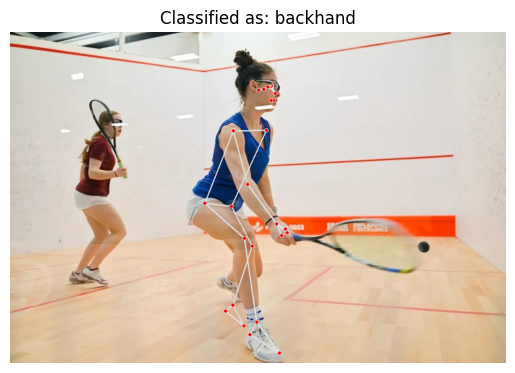

Processing: /content/squashWrong2.jpg
Prediction: backhand


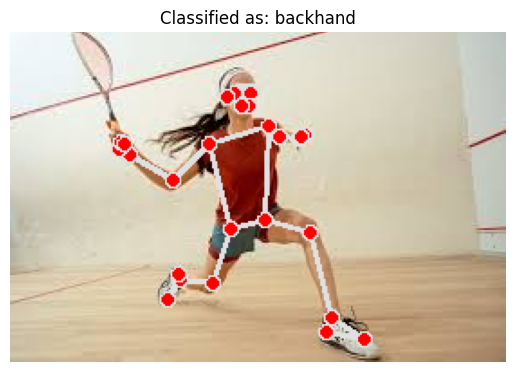

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=1)
mp_drawing = mp.solutions.drawing_utils

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="/content/tennis_pose_model_optimized.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to classify an uploaded image using TensorFlow Lite model
def classify_multiple_images(image_paths):
    for image_path in image_paths:
        print(f"Processing: {image_path}")
        classify_image(image_path)

def classify_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Check if the image was loaded correctly
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None

    # Convert the image to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform pose detection
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        # Extract pose keypoints
        keypoints = []
        for landmark in results.pose_landmarks.landmark:
            keypoints.append([landmark.x, landmark.y, landmark.z])

        # Flatten keypoints for prediction
        keypoints_flat = np.array([coord for kp in keypoints for coord in kp]).reshape(1, -1).astype(np.float32)

        # Set the input tensor with the pose keypoints
        interpreter.set_tensor(input_details[0]['index'], keypoints_flat)

        # Run the inference
        interpreter.invoke()

        # Get the model's prediction
        output_data = interpreter.get_tensor(output_details[0]['index'])[0]
        prediction = "forehand" if output_data > 0.5 else "backhand"
        print(f"Prediction: {prediction}")

        # Draw pose landmarks on the image
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Convert BGR image to RGB for displaying
        annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

        # Display the image with the pose skeleton
        plt.imshow(annotated_image_rgb)
        plt.title(f"Classified as: {prediction}")
        plt.axis('off')
        plt.show()

        return prediction
    else:
        print("No pose detected in the image.")
        return None

# List of image paths
image_paths = [
    "/squashwrong.jpg",
    "/content/squashWrong2.jpg"
]

# Process all images
classify_multiple_images(image_paths)